# 5.3 PPEs (just select one model)

- Run some simple pseudoproxy experiments:
    - ice cores ans speleothems jointly (later separed)
    - SNR=0.5 (hurts a bit, but well ...)
    - Zero Exp: Pure d18O
    - First Exp: PSM including fractionation + inf/prec weighting
    - Second Exp: Proxies are created with the filters. PSM on prior (using filter and not -> there shouldn't be a strong detrimental effect. The second could then be left out)

- **Noise**: Important: The noise is added on the original d18O, not anything else. SNR thus refers to the original d18O time series
             This is done on purpose to make the experiments no filter/filter better comparable. The evaluation metrics Correlation and CE are applied to the original temp/d18O field, and not the

- Plot in thesis:
    - For one model ((Corr,CE),(tsurf,d18O,prec))
    - Correlation without significance level (it's boring anyway)
    - global mean  value in one box in the corner (that allows for an easy comparison between plot)
    - both experiments should use the same colorbar and delimations (0 to 1 anyway)
    
Not for thesis, but important to look at (Appendix eventually)
    - Plots of experiments for each separate model
    - Look if things are consistent in each model

**DATA**
- original model resolution
- pseudoproxies from iso2k

In [1]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import copy

%load_ext autoreload
%autoreload 2

In [2]:
#CONFIG DICTIONARY (NEW)

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales
cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'reconstruct':['tsurf','d18O','prec'],
'basepath':'/home/mchoblet/paleoda/', #dont forget last slash
'output_folder':'experiment_Echam', #in cwd
'output_file':'Echam_realistic_PPE_snr1',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':False, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']],
'how_many': None, #use all 108/109 locations, that's easier.
'only_regional_proxies':False,
'regional_bounds':False,
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1,0.1], #irrelevant for PPE
#irrelevant for PPE
'time_scales': ['median','median'],
'proxy_time':['0851','1849'],
'time': ['0851','1849'], #das ist in allen modellen drin
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,

'psm':['speleo','icecore'], 
'interpol':None, #None/'dw'
'var_psm': ['d18O','d18O'] ,
'speleo':{
    'weighting': 'inf',#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},

###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': True,
    'SNR': [0.5,0.5], #signal to noise variance ratio
    'noise_bf_filt':True,
    'noise_type': 'w', #'w'/'r'
     #'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1],[1]], 
    'source': 'external', #internal/external
    'other_model': 
    {'vp':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
    'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
    'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
    'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','CE','RE','RMSE'],#'RMSE','RMSPE','MAE','MAPE'],
    'psm' : {
    'speleo': {'weighting':'inf', 'height': False, 'fractionation':True, 'fractionation_temp': 'regular', 'filter': False, 't_time': 2.5,},
    'icecore':{'weighting':'prec', 'height': False, 'filter': False,},
    },
},

###KALMAN-FILTER
'time': ['0851','1849'], #covered by all models
'nens':100, #ensemble members
'reps':1, #Monte Carlo
'full_fields': True, 
'proxy_frac': None,
'extra_assi': 
    {
        'globalmean': ['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': None, #['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': None, #'BG+HX', #/ 'HX'
'anomaly_time': None, #['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}


In [3]:
cfg_base=copy.deepcopy(cfg)

In [4]:
paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
} 

#I checked once again that nothing with the longitudes is wrong (all go from 0 to 360)
oro_dic={
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
}

In [5]:
cfg['ppe']['psm']['speleo']=cfg['speleo']
cfg['ppe']['psm']['icecore']=cfg['icecore']

In [6]:
cfg['reps']=10
cfg['ppe']['SNR']=[0.5,0.5]
cfg['var_psm']=['d18O','d18O']

## Experiments

In [20]:
models=list(paths.keys())
for model in models:
    if model=='iHadCM3':
        cfg['check_nan']=True

    cfg['vp']=paths[model]
    cfg['ppe']['other_model']['vp']=paths[model]

    cfg['output_folder']='thesis_5_3'

    cfg['ppe']['SNR']=[0.5,0.5]
    #LOOP OVER ALL MODELS (after echam has been tested)

    ####### BOTH SISAL and Iso2K
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=[None,None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    #4. psm experiment (ppe with noise, but prior no filter(no_frac))
    file='exp4_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': False,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    ####### ONLY SISAL
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=[None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    wrapper.paleoda_wrapper(cfg)

    #4. psm experiment (ppe with noise, but prior no filter(no_frac))
    file='exp4_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': False,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    wrapper.paleoda_wrapper(cfg)

    ####### ONLY Iso2k
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=[None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    #no exp 4 for ice cores (no fractionation middle step)


>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
Start Multitimescale DA loop.


100%|██████████| 10/10 [06:48<00:00, 40.87s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp0_iCESM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /hom

100%|██████████| 10/10 [07:14<00:00, 43.48s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp1_iCESM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:49<00:00,  1.01s/it]


COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
Noise added to d18O before filtering
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
Noise added to d18O before filtering
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:31<00:00,  1.19it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [07:19<00:00, 43.92s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp2_iCESM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /hom

100%|██████████| 109/109 [01:35<00:00,  1.14it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [07:15<00:00, 43.54s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp3_iCESM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computin

100%|██████████| 109/109 [01:52<00:00,  1.03s/it]


Start Multitimescale DA loop.


100%|██████████| 10/10 [07:20<00:00, 44.09s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp4_iCESM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
Start Multitimescale DA loop.


100%|██████████| 10/10 [06:48<00:00, 40.81s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp0_iCESM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850

100%|██████████| 10/10 [07:27<00:00, 44.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp1_iCESM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda

100%|██████████| 10/10 [07:20<00:00, 44.08s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp2_iCESM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850

100%|██████████| 10/10 [06:49<00:00, 40.90s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp3_iCESM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/pale

100%|██████████| 10/10 [07:31<00:00, 45.16s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp4_iCESM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
Start Multitimescale DA loop.


100%|██████████| 10/10 [07:18<00:00, 43.84s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp0_iCESM_iso.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda

100%|██████████| 10/10 [06:44<00:00, 40.45s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp1_iCESM_iso.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:34<00:00,  1.15it/s]


COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
Noise added to d18O before filtering
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:53<00:00,  1.04s/it]


Start Multitimescale DA loop.


100%|██████████| 10/10 [07:16<00:00, 43.63s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp2_iCESM_iso.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda

100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [05:17<00:00, 31.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp3_iCESM_iso.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
Start Multitimescale DA loop.


100%|██████████| 10/10 [08:50<00:00, 53.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp0_isoGSM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /ho

100%|██████████| 10/10 [08:51<00:00, 53.19s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp1_isoGSM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
Noise added to d18O before filtering
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
Noise added to d18O before filtering
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:21<00:00,  1.33it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [09:03<00:00, 54.39s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp2_isoGSM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /ho

100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [08:57<00:00, 53.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp3_isoGSM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computi

100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [08:54<00:00, 53.42s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp4_isoGSM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
Start Multitimescale DA loop.


100%|██████████| 10/10 [09:00<00:00, 54.01s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp0_isoGSM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_185

100%|██████████| 10/10 [09:05<00:00, 54.59s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp1_isoGSM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleod

100%|██████████| 10/10 [09:03<00:00, 54.39s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp2_isoGSM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_185

100%|██████████| 10/10 [09:06<00:00, 54.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp3_isoGSM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/pal

100%|██████████| 10/10 [09:05<00:00, 54.53s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp4_isoGSM_sisal.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
Start Multitimescale DA loop.


100%|██████████| 10/10 [08:52<00:00, 53.21s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp0_isoGSM_iso.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleod

100%|██████████| 10/10 [08:51<00:00, 53.16s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp1_isoGSM_iso.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
Noise added to d18O before filtering
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [08:56<00:00, 53.64s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp2_isoGSM_iso.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleod

100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [08:56<00:00, 53.68s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp3_isoGSM_iso.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
Start Multitimescale DA loop.


100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp0_Echam_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  fr

100%|██████████| 10/10 [01:43<00:00, 10.38s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp1_Echam_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
Noise added to d18O before filtering
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
Noise added to d18O before filtering
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [01:43<00:00, 10.31s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp2_Echam_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  fr

100%|██████████| 109/109 [01:21<00:00,  1.33it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp3_Echam_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.n

100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Start Multitimescale DA loop.


100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp4_Echam_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
Start Multitimescale DA loop.


100%|██████████| 10/10 [01:39<00:00,  9.99s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# The same with less noise (SNR=5).
SNR=100 is not a good idea, because there will be spurious covariances! High SNR is really a good example where the monte carlo repetitions become useful.

In [ ]:
cfg['ppe']['SNR']=[5,5]
cfg['reps']=10
models=list(paths.keys())
for model in models:
    
    #skip iCE
    if model=='iHadCM3':
        cfg['check_nan']=True

    cfg['vp']=paths[model]
    cfg['ppe']['other_model']['vp']=paths[model]

    cfg['output_folder']='thesis_5_3_nonoise'
    #LOOP OVER ALL MODELS (after echam has been tested)

    ####### BOTH SISAL and Iso2K
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=[None,None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    #4. psm experiment (ppe with noise, but prior no filter(no_frac))
    file='exp4_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': False,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    ####### ONLY SISAL
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=[None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    wrapper.paleoda_wrapper(cfg)

    #4. psm experiment (ppe with noise, but prior no filter(no_frac))
    file='exp4_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': False,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    wrapper.paleoda_wrapper(cfg)

    ####### ONLY Iso2k
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=[None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    #no exp 4 for ice cores (no fractionation middle step)
    


>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 5
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 5
Start Multitimescale DA loop.


100%|██████████| 10/10 [09:21<00:00, 56.15s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp0_iCESM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Changed Pseudoproxy-PSM-Config for  icecore
Load d18O  from  /hom

100%|██████████| 10/10 [12:07<00:00, 72.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to exp1_iCESM_all.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER
Noise added to d18O before filtering


  0%|          | 0/109 [00:00<?, ?it/s]

In [13]:
cfg['anomaly']=None#'BG+HX'
cfg['how_many']=None

model='Echam'
cfg['vp']=paths[model]
cfg['ppe']['other_model']['vp']=paths[model]
cfg['output_folder']='thesis_5_3_nonoise'

cfg['ppe']['SNR']=[100,100]
cfg['var_psm']=['tsurf','tsurf']
#cfg['ppe']['SNR']=[5,5]
#LOOP OVER ALL MODELS (after echam has been tested)
cfg['time']=['0850','1849']
#cfg['proxy_time']=['0851','1850']
cfg['proxy_time']=['0850','1849']

####### BOTH SISAL and Iso2K
cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
#cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
#cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_full.nc','/home/mchoblet/paleoda/data/proxy_dbs/sisal_db_full.nc']

#0. no psm experiment (here source can be the same)
file='exp0_'+model+'_all'
cfg['output_file']=file

#cfg['psm']=[None,None]
cfg['reps']=10

cfg['psm']=[None,None]
cfg['ppe']['noise_bf_filt']= False
cfg['ppe']['source']='internal'

p_5=wrapper.paleoda_wrapper(cfg)

[autoreload of utils failed: Traceback (most recent call last):
  File "/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/mchoblet/paleoda/utils.py", line 1109
    import pdb
IndentationError: unexpected

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 100
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 100
Start Multitimescale DA loop.


 20%|██        | 2/10 [00:24<01:38, 12.31s/it]


KeyboardInterrupt: 

In [78]:
original=dataloader.annual_mean(xr.open_dataset('/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc')['tsurf'])[1:]

In [13]:
for model in models:    
    if model=='iHadCM3':
        cfg['check_nan']=True
    cfg=copy.deepcopy(cfg_base)            
    cfg['vp']=paths[model]
    cfg['ppe']['other_model']['vp']=paths[model]

    cfg['output_folder']='thesis_5_3_nonoise'
    
    cfg['ppe']['SNR']=[10,10]
    #LOOP OVER ALL MODELS (after echam has been tested)

    ####### BOTH SISAL and Iso2K
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=[None,None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    #4. psm experiment (ppe with noise, but prior no filter(no_frac))
    file='exp4_'+model+'_all'
    cfg['output_file']=file

    cfg['psm']=['speleo','icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': False,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    ####### ONLY SISAL
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=[None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']=cfg['speleo']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    wrapper.paleoda_wrapper(cfg)

    #4. psm experiment (ppe with noise, but prior no filter(no_frac))
    file='exp4_'+model+'_sisal'
    cfg['output_file']=file

    cfg['psm']=['speleo']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': False,
     'fractionation_temp': 'regular',
     'filter': False,
     't_time': 2.5}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['speleo']={'weighting': 'inf',
     'height': False,
     'fractionation': True,
     'fractionation_temp': 'regular',
     'filter': True,
     't_time': 2.5}

    wrapper.paleoda_wrapper(cfg)

    ####### ONLY Iso2k
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']

    #0. no psm experiment (here source can be the same)
    file='exp0_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=[None]
    cfg['ppe']['noise_bf_filt']= False
    cfg['ppe']['source']='internal'

    wrapper.paleoda_wrapper(cfg)

    #1. psm experiment
    file='exp1_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #2. psm experiment 
    file='exp2_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']=cfg['icecore']

    wrapper.paleoda_wrapper(cfg)

    #3. psm experiment (ppe with noise, but prior no filter(with_frac))
    file='exp3_'+model+'_iso'
    cfg['output_file']=file

    cfg['psm']=['icecore']
    cfg['ppe']['noise_bf_filt']= True
    cfg['ppe']['source']='external'

    #specific PSM Options (applied to both the prior and the pseudoproxies)
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

    #"external" model psm setup has to be the same psm config as used for prior modificatioin
    cfg['ppe']['psm']['icecore']={'weighting': 'prec', 'height': False, 'filter': True}

    wrapper.paleoda_wrapper(cfg)

    #no exp 4 for ice cores (no fractionation middle step)

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 10
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 10
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:44<00:00, 104.08s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average


KeyboardInterrupt: 

# Plots

Spacing between subplot rows https://stackoverflow.com/questions/51717199/how-to-adjust-space-between-every-second-row-of-subplots-in-matplotlib

- extent to 4th panel: no filter on the psm


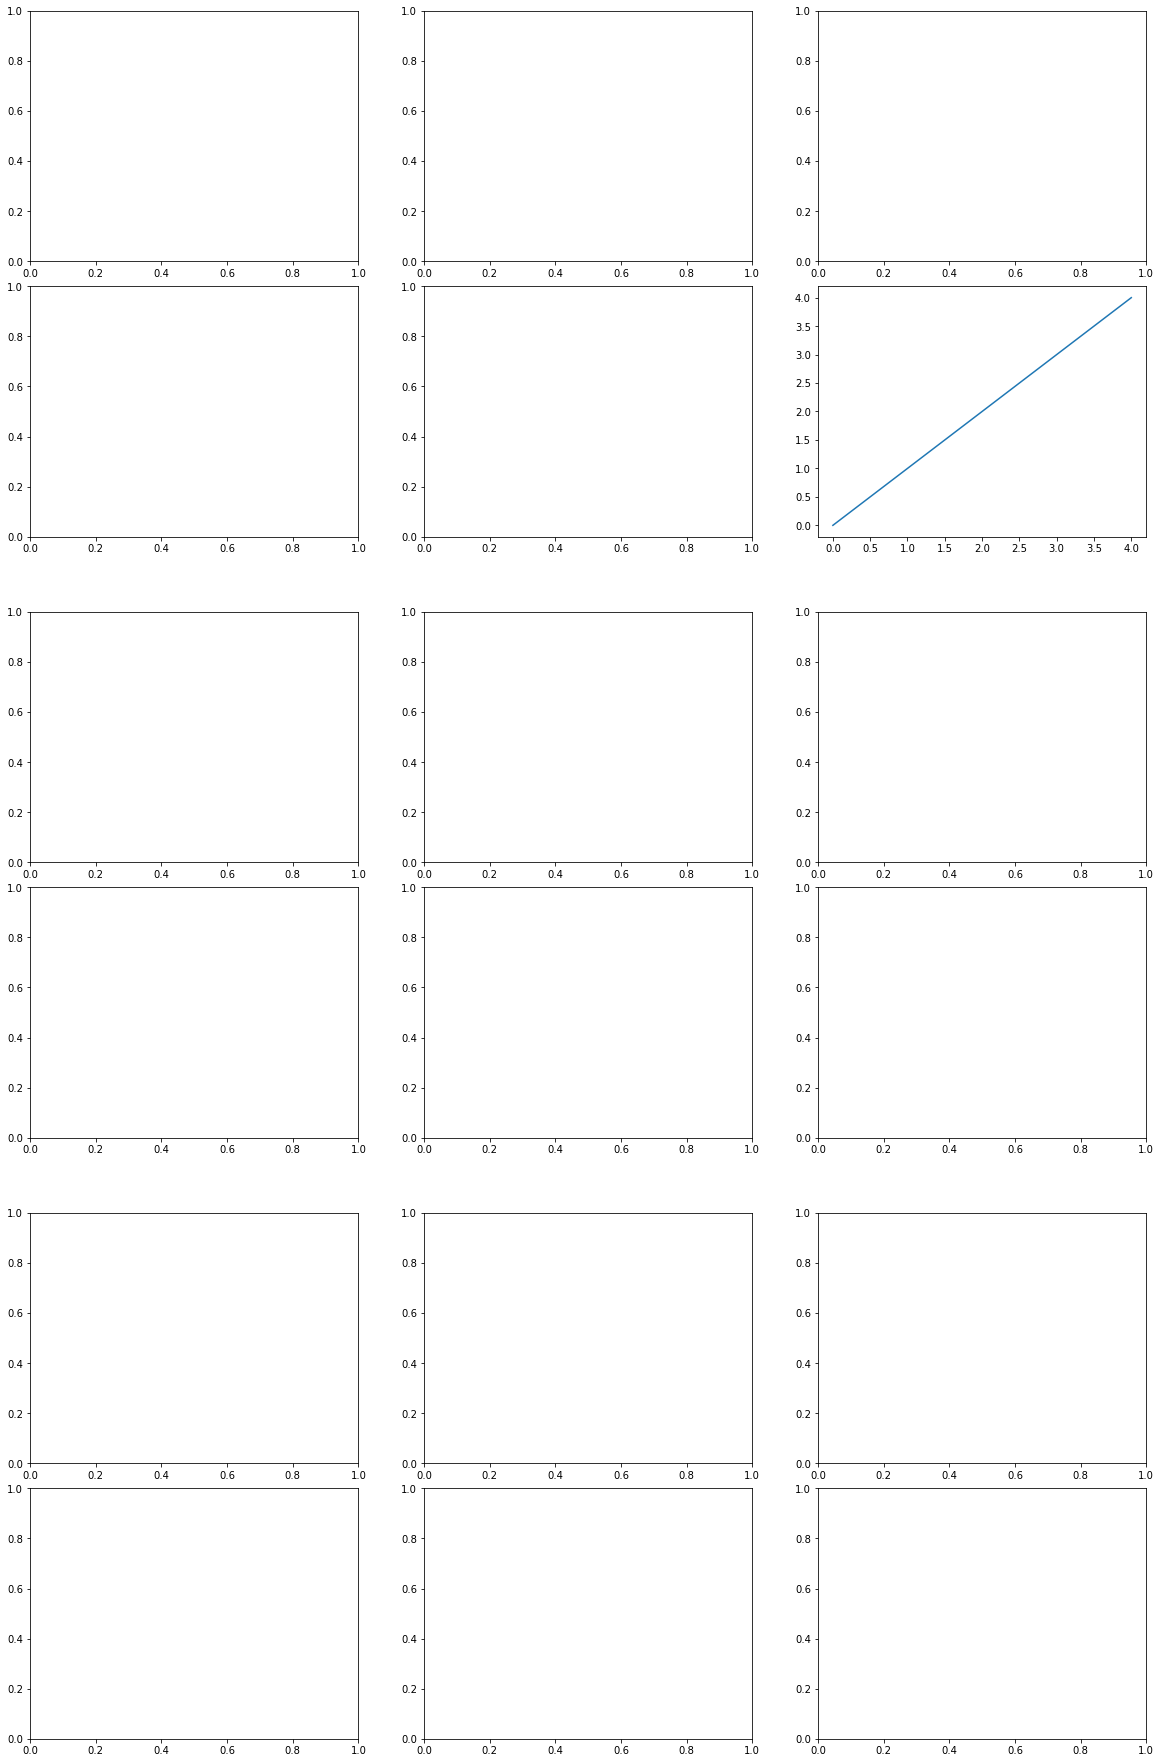

In [79]:
from matplotlib.gridspec import GridSpec

n = 3 # number of double-rows
m = 3 # number of columns

t = 0.9 # 1-t == top space 
b = 0.1 # bottom space      (both in figure coordinates)

msp = 0.1 # minor spacing
sp = 0.3  # major spacing

offs=(1+msp)*(t-b)/(2*n+n*msp+(n-1)*sp) # grid offset
hspace = sp+msp+1 #height space per grid

gso = GridSpec(n,m, bottom=b+offs, top=t, hspace=hspace)
gse = GridSpec(n,m, bottom=b, top=t-offs, hspace=hspace)

fig = plt.figure(figsize=(20,30))
axes = []
for i in range(n*m):
    axes.append(fig.add_subplot(gso[i]))
    axes.append(fig.add_subplot(gse[i]))

In [7]:
###
def plot_ppe(basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_3/',model='Echam',proxy='all', p_val=False,):
     #All models
     #iso #sisal

    if proxy=='all':
        proxies=[xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc'), xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc')]
    elif proxy=='sisal':
        proxies=[xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc')]
    elif proxy=='iso':
        proxies=[xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc')]

    vmax=1
    vmin=-1

    metrics=['Corr','CE']
    link0=basepath+'exp0_'+model+'_'+proxy+'.nc'
    link1=basepath+'exp1_'+model+'_'+proxy+'.nc'
    link2=basepath+'exp2_'+model+'_'+proxy+'.nc'

    data0=xr.open_dataset(link0)
    data1=xr.open_dataset(link1)
    data2=xr.open_dataset(link2)

    #sns.set_theme(style="white")

    from matplotlib.gridspec import GridSpec

    n = 3 # number of double-rows
    m = 3 # number of columns

    t = 0.9 # 1-t == top space 
    b = 0.1 # bottom space      (both in figure coordinates)

    msp = 0.05 # minor spacing
    sp = 0.4  # major spacing

    offs=(1+msp)*(t-b)/(2*n+n*msp+(n-1)*sp) # grid offset
    hspace = sp+msp+1 #height space per grid

    gso = GridSpec(n,m, bottom=b+offs, top=t, hspace=hspace)
    gse = GridSpec(n,m, bottom=b, top=t-offs, hspace=hspace)

    fig = plt.figure(figsize=(20,20))
    axes = []
    for i in range(n*m):
        axes.append(fig.add_subplot(gso[i],projection=ccrs.PlateCarree()))
        axes.append(fig.add_subplot(gse[i],projection=ccrs.PlateCarree()))


    for i, da in enumerate([data0,data1,data2]):

        for j,var in enumerate(['tsurf','d18O','prec']):

            #Corr
            ax=axes[(i*3+j)*2]
            data=da[(var+'_Corr')]
            mean=utils.globalmean(data).values

            p1=da[(var+'_Corr')].plot(ax=ax,vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)

            ax.add_feature(cfeature.COASTLINE)
            #ax.text(.01, .99, np.round(mean,2), ha='left', va='top', transform=ax.transAxes,fontsize=20)
            if j==0:
                ax.axes.yaxis.set_visible(True)
                ax.set_ylabel('Corr',fontsize=30,labelpad=60,rotation=0)
            ax.tick_params(left = False,labelleft = False )
            
            props = dict(boxstyle='round', facecolor='wheat', alpha=1)
            ax.text(0.88,0.95,np.round(mean,2), transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)     
            
            if p_val:
                da[(var+'_p_value')].plot.contourf(levels=[0.01,1],colors='none',hatches=[None,'--'],add_colorbar=False, extend='both',ax=ax)
                #sig.plot.contourf(ax=ax,levels = [-1*t95, -1*t90, t90, t95], colors='none', hatches=['..', None, None, None, '..'], extend='both', add_colorbar=False, transform=ccrs.PlateCarree())
            
            #CE
            ax=axes[(i*3+j)*2+1]     
            data=da[(var+'_CE')]
            mean=utils.globalmean(data).values
            p1=data.plot(ax=ax,vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
            #ax.text(.01, .99, np.round(mean,2), ha='left', va='top', transform=ax.transAxes,fontsize=20)
            ax.add_feature(cfeature.COASTLINE)
            if j==0:
                ax.axes.yaxis.set_visible(True)
                ax.set_ylabel('CE',fontsize=30,labelpad=60,rotation=0)
            ax.tick_params(left = False,labelleft = False)

            #if printmean:
            props = dict(boxstyle='round', facecolor='wheat', alpha=1)
            ax.text(0.88,0.95,np.round(mean,2), transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)     

            if proxies!=None:
                for p in proxies:
                    scatter=axes[(i*3+j)*2].scatter(p['lon'],p['lat'],c='grey',s=10,marker='x', transform=ccrs.PlateCarree())
                    scatter=axes[(i*3+j)*2+1].scatter(p['lon'],p['lat'],c='grey',s=10,marker='x', transform=ccrs.PlateCarree())

    p_0 = axes[-3].get_position().get_points().flatten()
    #p_1 = axes[1,2].get_position().get_points().flatten()

    ax_cbar = fig.add_axes([p_0[0], p_0[1]-0.05, p_0[2]-p_0[0], 0.02])
    cbar=fig.colorbar(p1, cax=ax_cbar, orientation='horizontal')
    cbar.ax.tick_params(labelsize=25)

    #cb.set_label('$\overline{{Proxy}}$ - $\overline{Simulation}$',fontsize=30)

    axes[0].text(-0.1, 1.18, 'a)', transform=axes[0].transAxes, size=35)
    axes[6].text(-0.1, 1.18, 'b)', transform=axes[6].transAxes, size=35)

    axes[12].text(-0.1, 1.18, 'c)', transform=axes[12].transAxes, size=35)
    #axes[12].text(-0.1, 1.18, 'd)', transform=axes[12].transAxes, size=24)

    axes[0].set_title('Tsurf',fontsize=30)
    axes[2].set_title('$\delta^{18}O$',fontsize=30)
    axes[4].set_title('Prec',fontsize=30)
    
    return fig

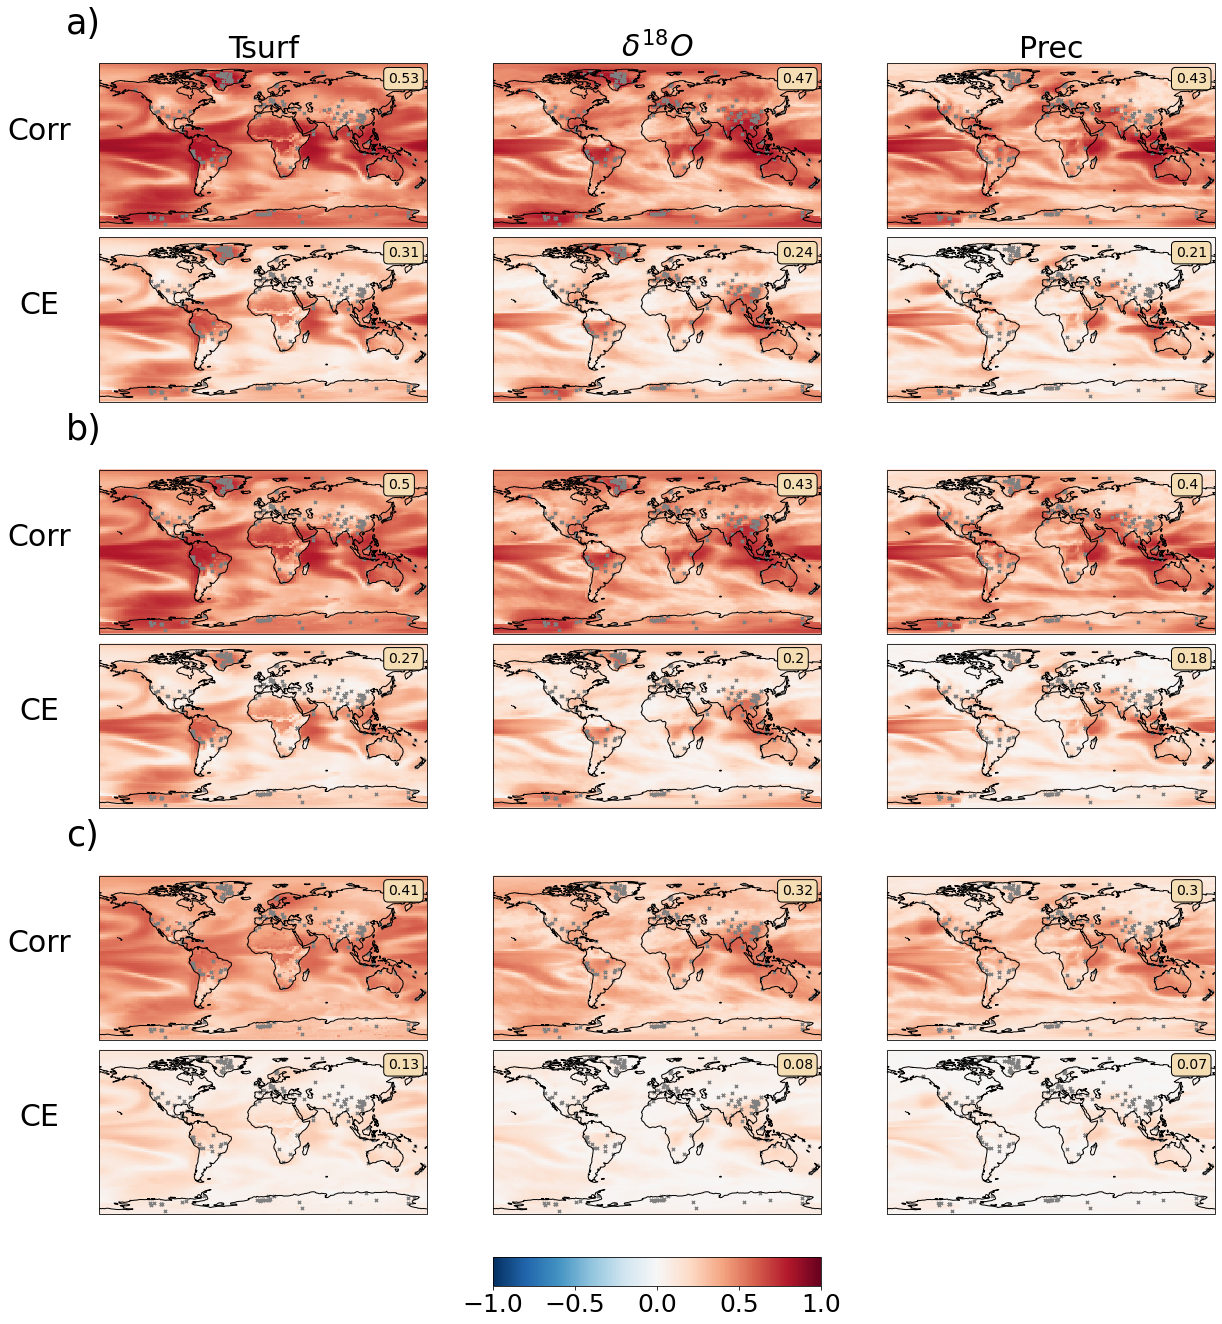

In [12]:
# PLOT THESIS
iCESM_ppe=plot_ppe(basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_3/',model='iCESM',proxy='all',p_val=False)

In [14]:
iCESM_ppe.savefig('/home/mchoblet/plots_thesis/5_3/iCESM_ppe.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

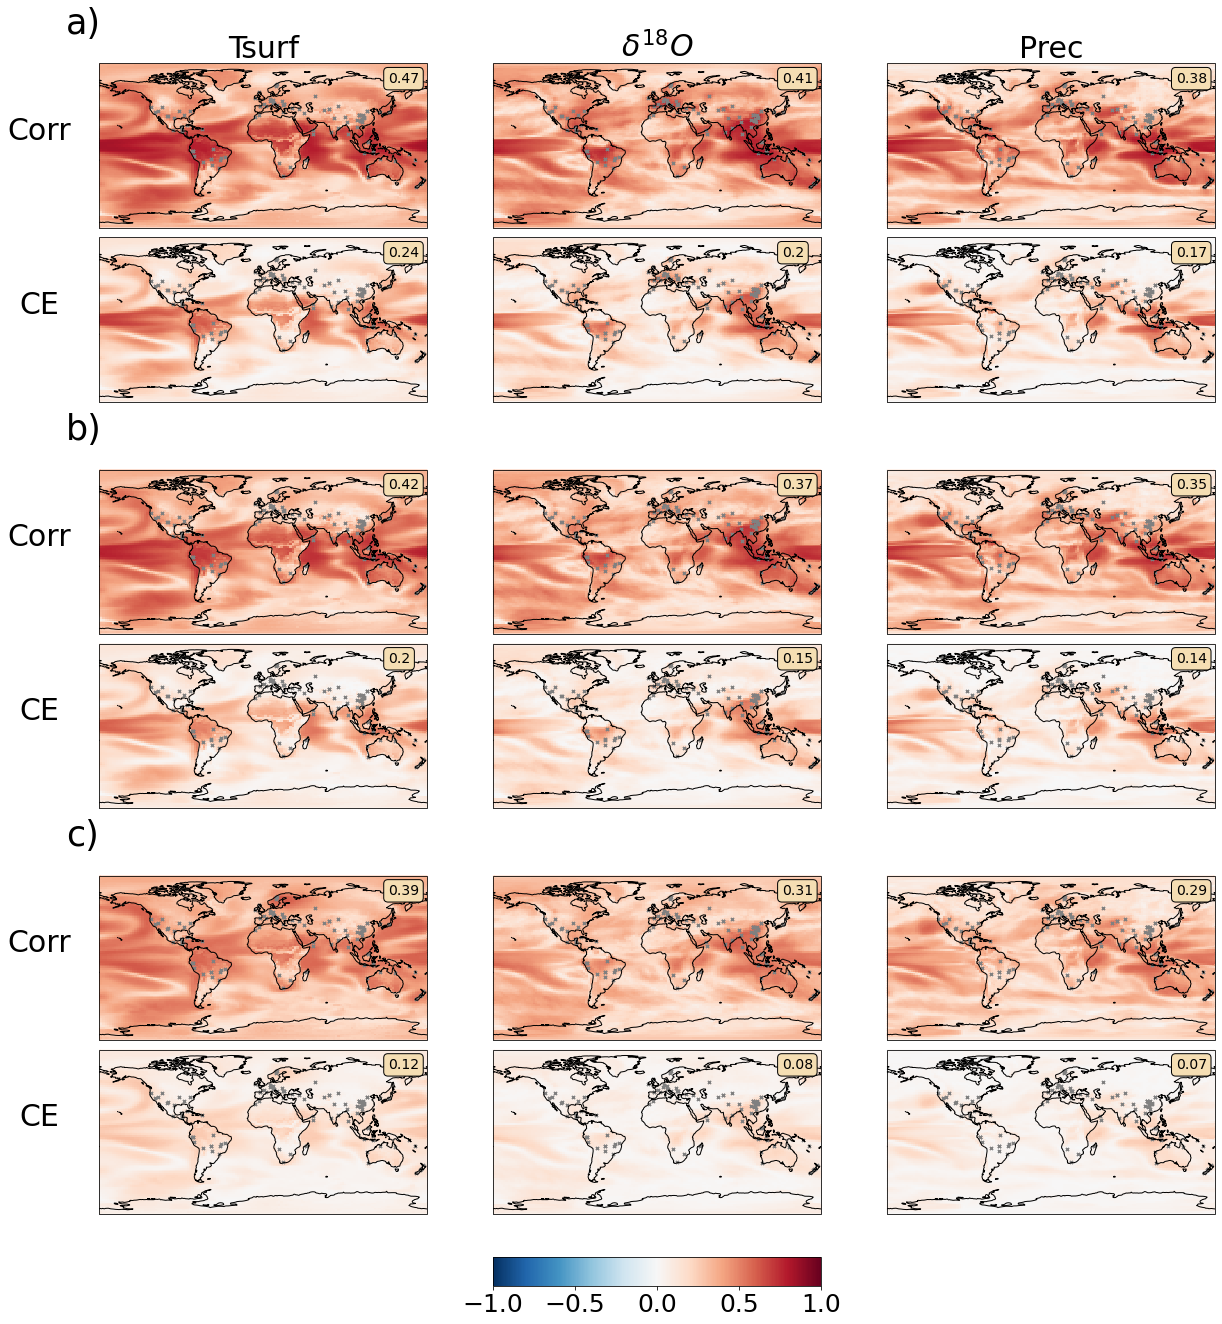

In [15]:
# PLOT THESIS (SISAL)
iCESM_ppe_sis=plot_ppe(basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_3/',model='iCESM',proxy='sisal',p_val=False)

In [16]:
iCESM_ppe_sis.savefig('/home/mchoblet/plots_thesis/5_3/iCESM_ppe_sisal.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

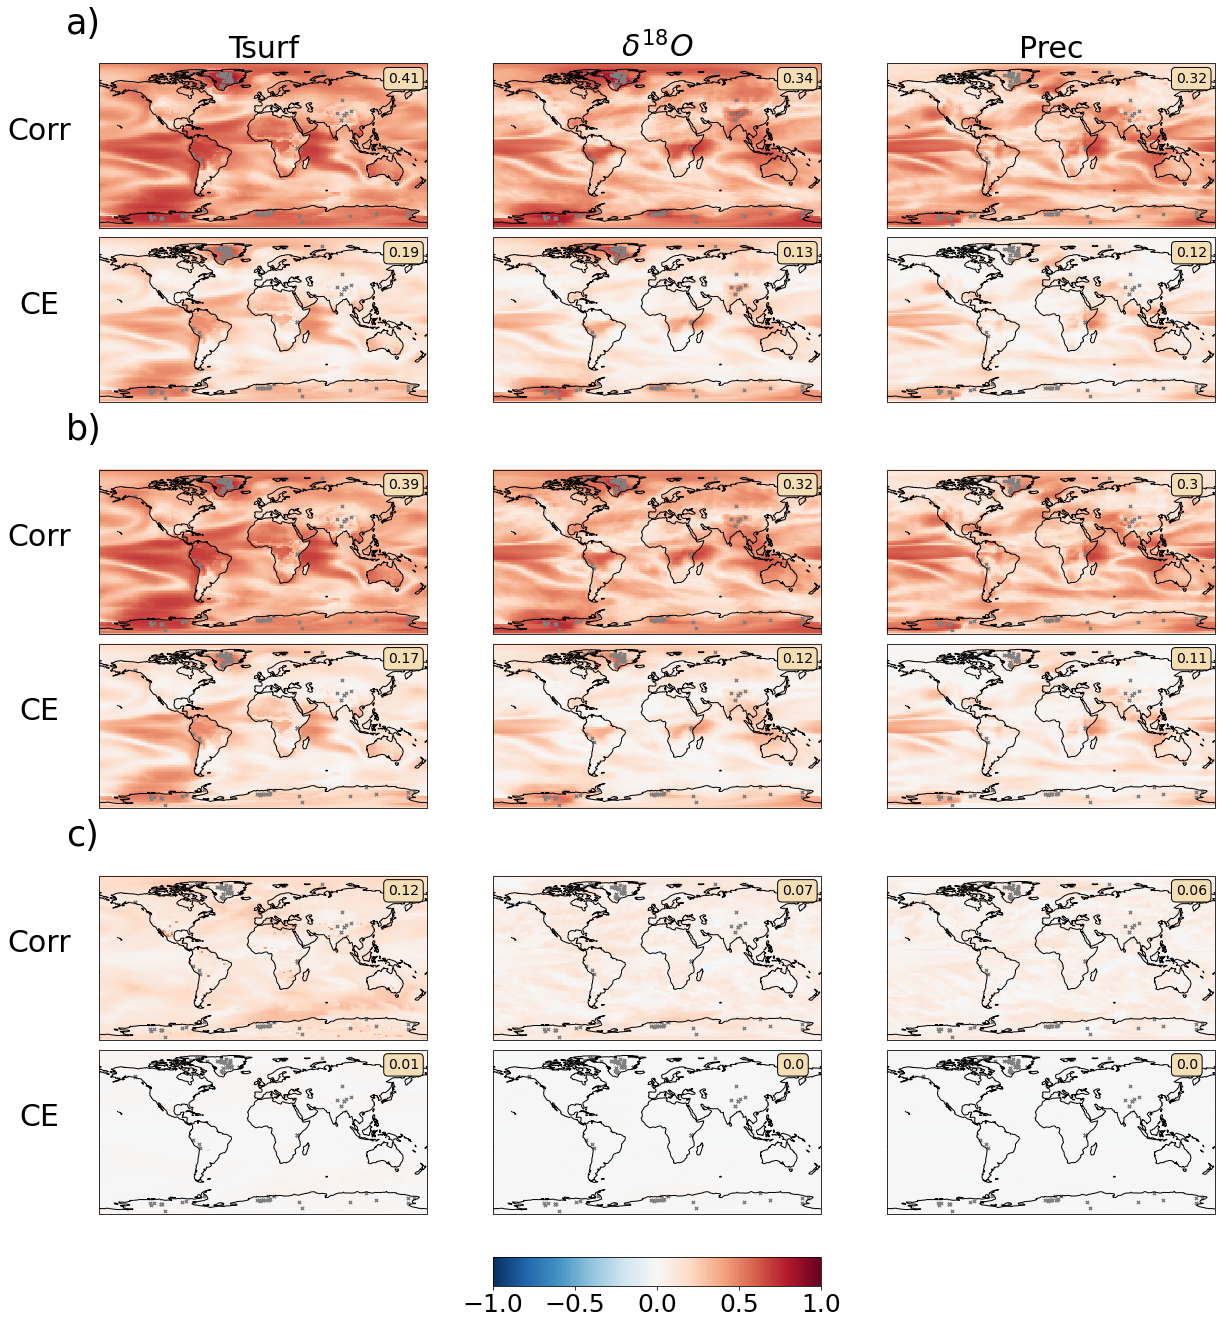

In [23]:
# PLOT THESIS (iso)<
iCESM_ppe_iso=plot_ppe(basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_3/',model='iCESM',proxy='iso',p_val=False)

In [18]:
iCESM_ppe_iso.savefig('/home/mchoblet/plots_thesis/5_3/iCESM_ppe_iso.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

In [ ]:
#CONFIG DICTIONARY (NEW)

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales
cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'reconstruct':['tsurf','d18O','prec'],
'basepath':'/home/mchoblet/paleoda/', #dont forget last slash
'output_folder':'experiment_Echam', #in cwd
'output_file':'Echam_realistic_PPE_snr1',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':False, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']],
'how_many': None, #use all 108/109 locations, that's easier.
'only_regional_proxies':False,
'regional_bounds':False,
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1,0.1], #irrelevant for PPE
#irrelevant for PPE
'time_scales': ['median','median'],
'proxy_time':['0851','1849'],
'time': ['0851','1849'], #das ist in allen modellen drin
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,

'psm':['icecore'], 
'interpol':None, #None/'dw'
'var_psm': ['d18O','d18O'] ,
'speleo':{
    'weighting': 'inf',#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},

###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': True,
    'SNR': [0.5,0.5], #signal to noise variance ratio
    'noise_bf_filt':True,
    'noise_type': 'w', #'w'/'r'
     #'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1],[1]], 
    'source': 'external', #internal/external
    'other_model': 
    {'vp':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
    'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
    'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
    'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','CE','RE','RMSE'],#'RMSE','RMSPE','MAE','MAPE'],
    'psm' : {
    'speleo': {'weighting':'inf', 'height': False, 'fractionation':True, 'fractionation_temp': 'regular', 'filter': False, 't_time': 2.5,},
    'icecore':{'weighting':'prec', 'height': False, 'filter': False,},
    },
},

###KALMAN-FILTER
'time': ['0851','1849'], #covered by all models
'nens':100, #ensemble members
'reps':1, #Monte Carlo
'full_fields': True, 
'proxy_frac': None,
'extra_assi': 
    {
        'globalmean': ['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': None, #['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': None, #'BG+HX', #/ 'HX'
'anomaly_time': None, #['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}


In [19]:
cfg['SNR']

KeyError: 'SNR'

In [28]:
cfg['psm']=[None]
cfg['ppe']['source']='internal'
cfg['var_psm']=['d18O']
cfg['ppe']['SNR']=[0.5]
cfg['noise_bf_filt']=False

# PLOT THESIS
####### BOTH SISAL and Iso2K
cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']

#0. no psm experiment (here source can be the same)
#file='exp0_'+model+'_all'
#cfg['output_file']=file

cfg['psm']=[None]
cfg['ppe']['noise_bf_filt']= False
cfg['ppe']['source']='internal'

wrapper.paleoda_wrapper(cfg)

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: None
GENERATING PSEUDOPROXIES FROM SAME MODEL
>>>>>>>>>>>>GENERATING pseudoproxies with SNR: 0.5
> /home/mchoblet/paleoda/utils.py(1119)pseudoproxy_generator()
   1117 
   1118                 #cut pseudoproxies in time
-> 1119                 pp_y=pp_y.sel(time=slice(c.proxy_time[0],c.proxy_time[1]))
   1120                 pp_r=pp_r.sel(time=slice(c.proxy_time[0],c.proxy_time[1]))
   1121 



ipdb>  pp_r[0]


<xarray.DataArray (site: 109)>
array([1.8815347 , 1.8815347 , 1.8815347 , 2.40965654, 1.90752192,
       1.93583275, 2.33634799, 2.32332873, 6.38656115, 1.01063312,
       1.01063312, 1.01063312, 1.01063312, 1.01063312, 1.95601305,
       3.75860465, 4.10457716, 3.9081356 , 8.2415672 , 8.2415672 ,
       1.82718774, 3.19879235, 3.19879235, 3.19879235, 3.19879235,
       2.99687861, 2.58036058, 3.0401211 , 1.60789355, 4.16266481,
       3.22065082, 4.45376334, 3.55372603, 1.74355488, 1.74355488,
       2.02977869, 2.05494171, 1.85072044, 1.72416708, 1.72416708,
       1.72416708, 1.72416708, 1.02027802, 2.99027435, 2.96419367,
       3.13744057, 3.13744057, 2.94172668, 0.8396966 , 3.05038666,
       3.05038666, 3.05038666, 3.05038666, 3.05038666, 3.05038666,
       1.11930883, 1.61326514, 4.0440961 , 1.42156683, 3.62284688,
       3.39108197, 3.2432454 , 3.10553223, 3.10553223, 1.7409338 ,
       3.15738017, 5.242405  , 2.09398147, 2.09398147, 3.15738017,
       1.7409338 , 1.7409338 , 

ipdb>  q


BdbQuit: 

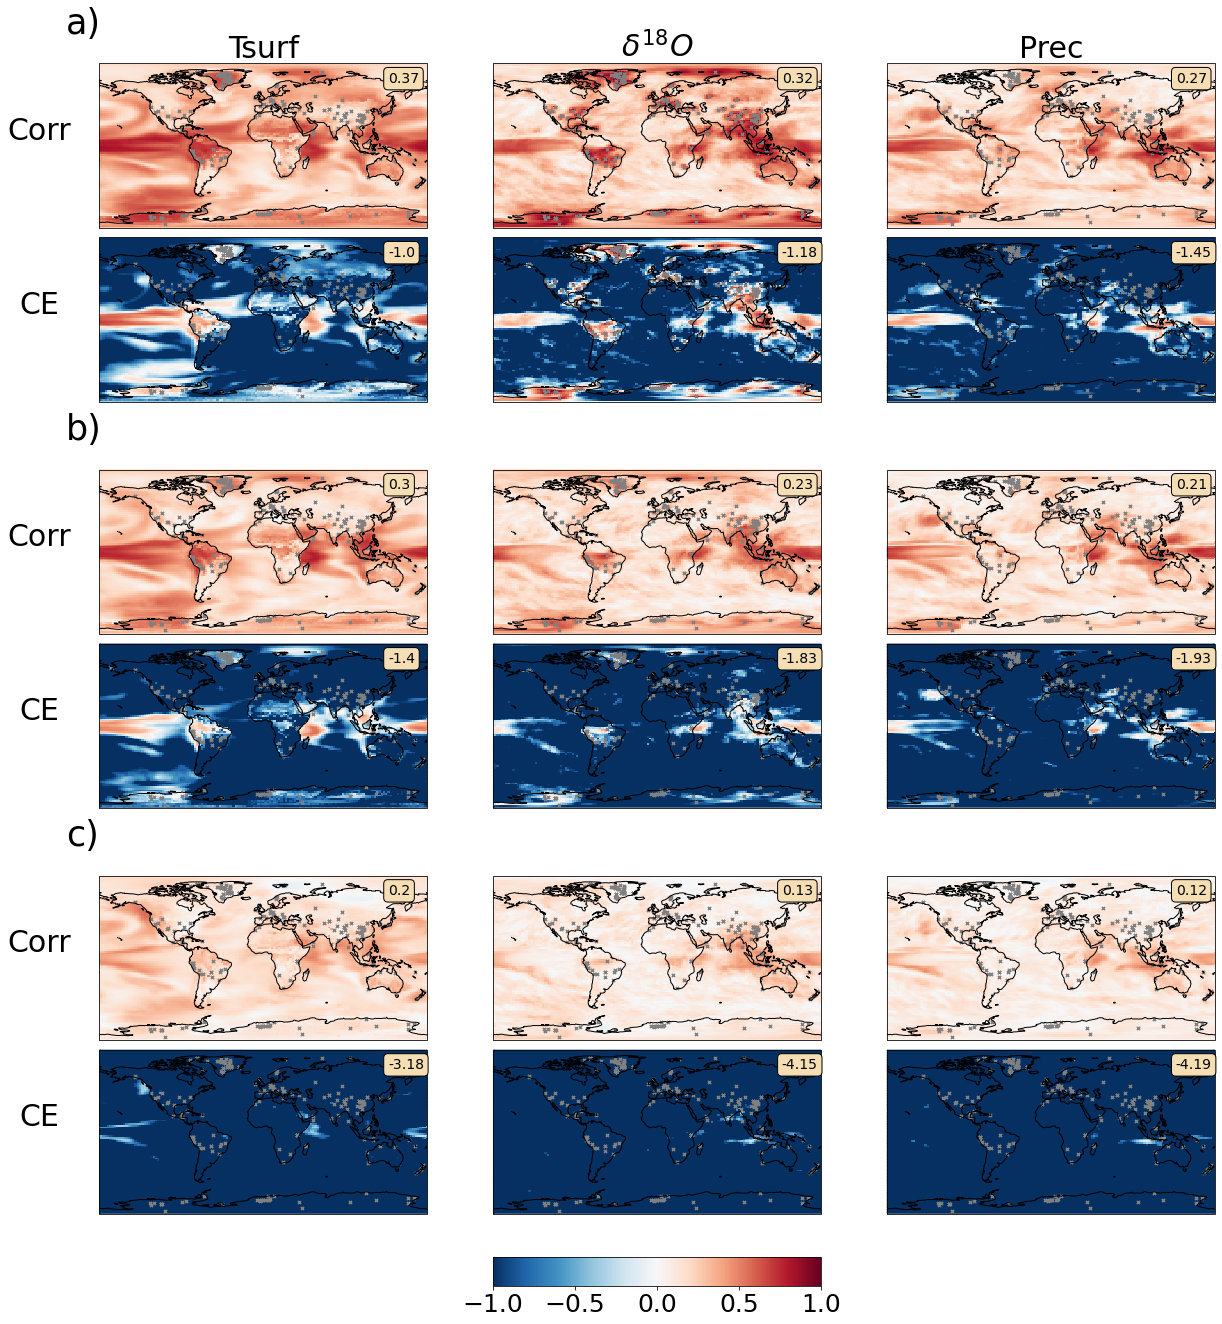

In [7]:
ech_all=plot_ppe(basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_3_nonoise/',model='iCESM',proxy='all',p_val=False)

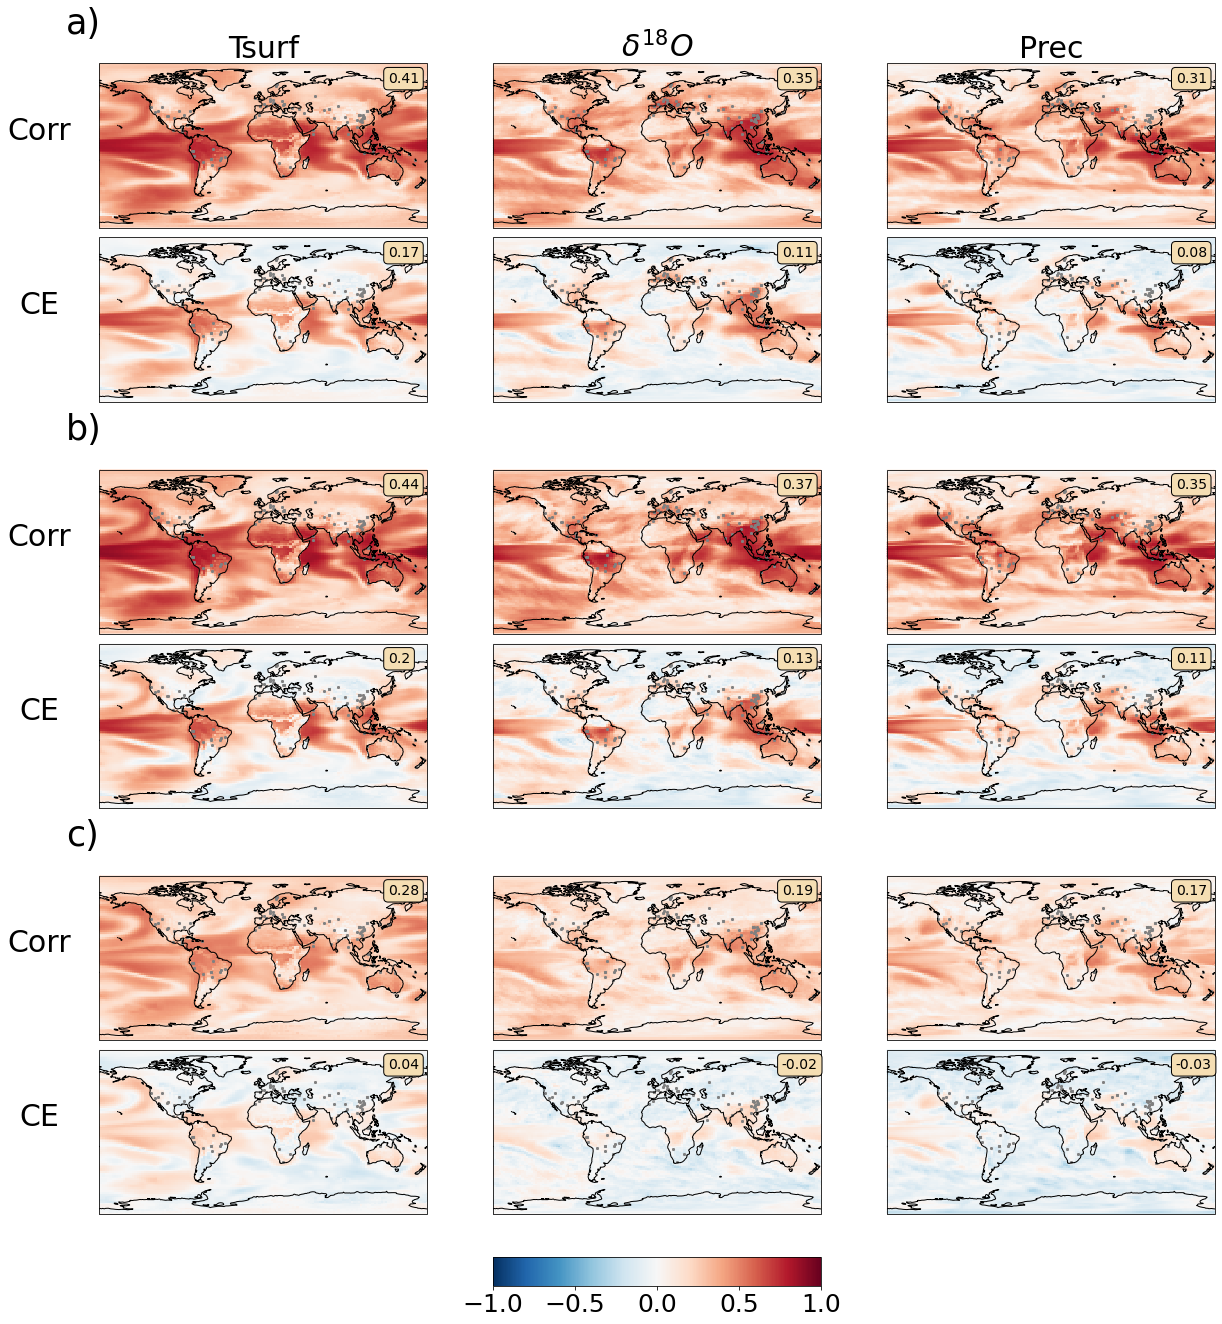

In [44]:
ech_all=plot_ppe(basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_3/',model='iCESM',proxy='sisal')

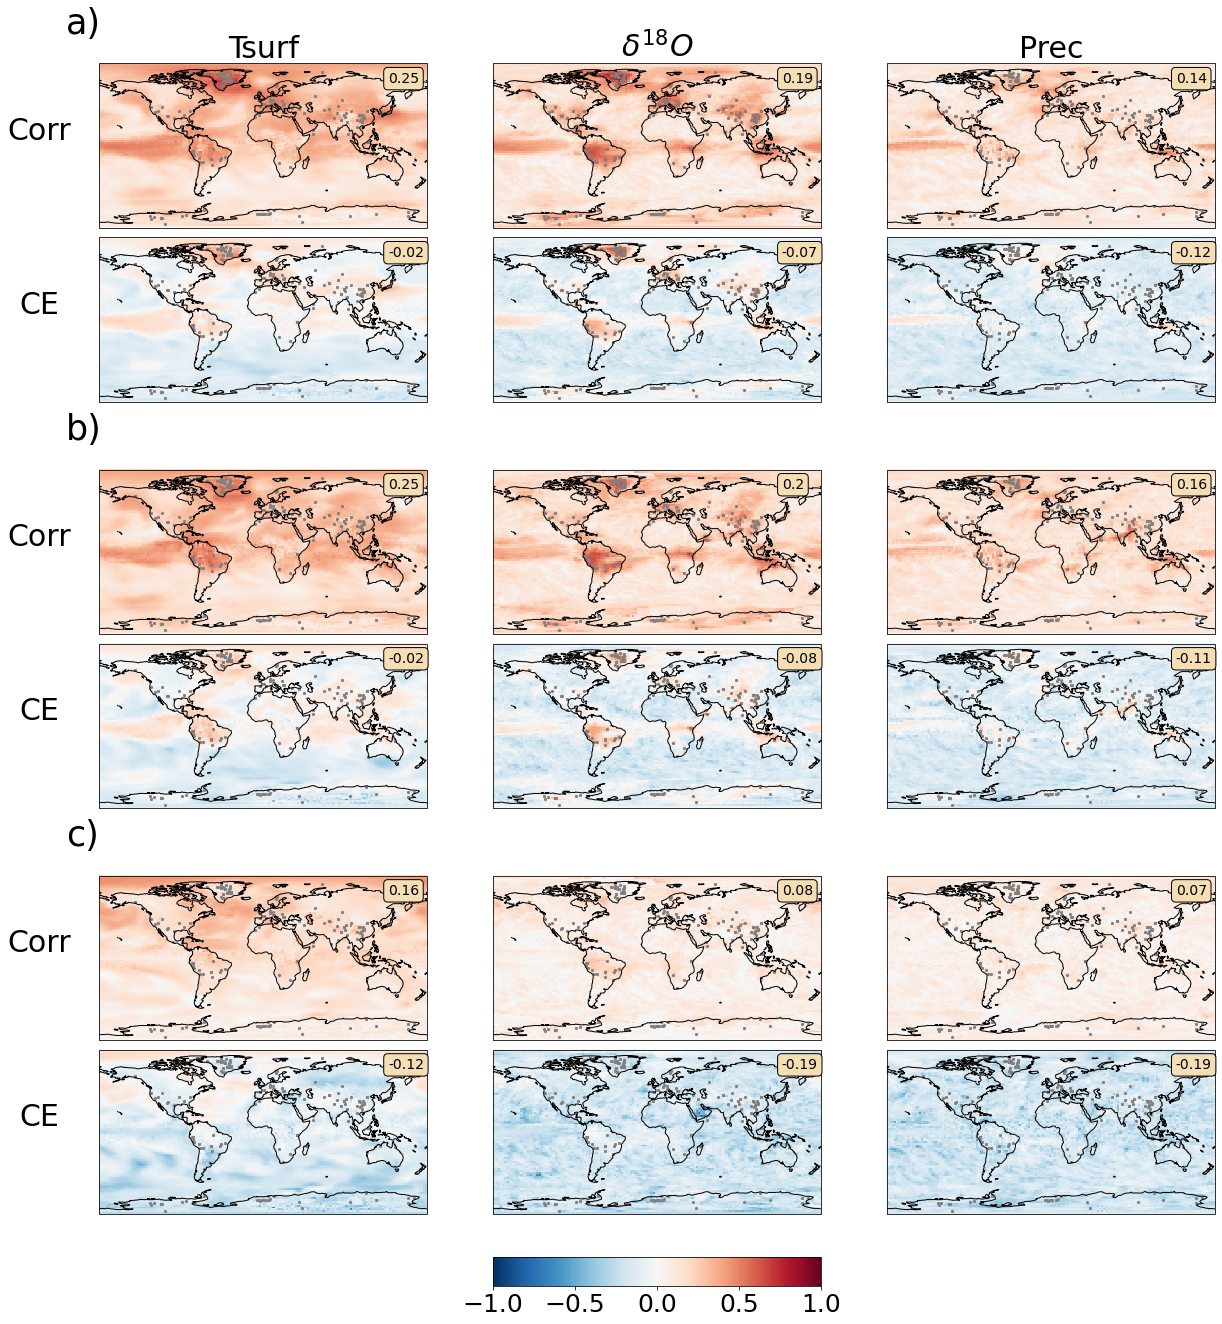

In [48]:
ech_all=plot_ppe(basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_3/',model='GISS',proxy='all')

In [ ]:
"""
plt.show()

#get first list item
conf=0

figsize=(int(15*1.2),int(6*1.2))
fig, axes = plt.subplots(ncols=3,nrows=2,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})

vmin=-1
vmax=1

color='grey'
size=5
ms='x'

for i, m in enumerate([data0,data1,data2]):
    

for i,m in enumerate(metrics):
    
    #temperature    
    string='tsurf'+'_'+m
    p1=results[string].plot(ax=axes[i,0],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
    
    ax=axes[i,0]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_ylabel(m,fontsize=30,rotation=0)
    ax.set_xlabel('',fontsize=30,rotation=0)
    ax.yaxis.set_label_coords(-0.14,0.45)
    
    
    ax.scatter(lons,lats,c=color,s=size, markerstyle='x',transform=ccrs.PlateCarree())
    
    #d18O
    string='d18O'+'_'+m
    p2=results[string].plot(ax=axes[i,1],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)

    ax=axes[i,1]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_ylabel('',fontsize=50,rotation=0)
    ax.set_xlabel('',fontsize=30,rotation=0)

    ax.scatter(lons,lats,c=color,s=size, transform=ccrs.PlateCarree())
    
    #precipitation
    string='prec'+'_'+m
    p3=results[string].plot(ax=axes[i,2],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
    
    ax=axes[i,2]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_xlabel('',fontsize=30,rotation=0)
    ax.set_ylabel('',fontsize=30,rotation=0)

    ax.scatter(lons,lats,c=color,s=size, transform=ccrs.PlateCarree())
    
p_0 = axes[0,2].get_position().get_points().flatten()
p_1 = axes[1,2].get_position().get_points().flatten()

ax_cbar = fig.add_axes([p_1[2]+0.01, p_1[1], 0.01, p_0[3]-p_1[1]])
cbar=fig.colorbar(p1, cax=ax_cbar, orientation='vertical')
cbar.ax.tick_params(labelsize=25)

#cb.set_label('$\overline{{Proxy}}$ - $\overline{Simulation}$',fontsize=30)

axes[0,0].set_title('Tsurf',fontsize=30)
axes[0,1].set_title('$\delta^{18}O$',fontsize=30)
axes[0,2].set_title('Prec',fontsize=30)

plt.savefig('/home/mchoblet/paleoda/results/plots/thesis_draft/echam_snr1.pdf', format='pdf',bbox_inches='tight')

#plt.tight_layout() 
"""